In [1]:
# library for mathematical functions and data preprocessing such as table, etc
import pandas as pd
from scipy.stats import skew

# Library for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

# Library for machine learning functions/algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

In [2]:
# data itself
url = 'lending_club_loan_two.csv'
df_before = pd.read_csv(url)
df_before.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [3]:
# Reason:
# These features lack direct relevance to a person's ability to secure a loan. 
# grade and subgrade, summarizes the loan status, can be substituted with existing data like interest rates and annual income

columns_to_drop = ['emp_title', 'address', 'issue_d', 'title', 'earliest_cr_line', 'initial_list_status', 'grade', 'sub_grade', 'purpose']
df_before = df_before.drop(columns=columns_to_drop)

In [4]:
# label encoder and fit_transform is a function that changes/remap string into number based on alphabetical order
le = LabelEncoder() 
df_before['term'] = le.fit_transform(df_before['term'])
# 36 months = 0,  60 months = 1

df_before['emp_length'] = le.fit_transform(df_before['emp_length'])
# '1 year' = 0, '10+ years' = 1, '2 years' = 2, '3 years' = 3, '4 years' = 4, '5 years' = 5,   
# '6 years' = 6, '7 years' = 7, '8 years' = 8,  '9 years' = 9, '< 1 year' = 10

df_before['home_ownership'] = le.fit_transform(df_before['home_ownership'])
# 'ANY' = 0, 'MORTGAGE' = 1, 'NONE' = 2, 'OTHER' = 3, 'OWN' = 4, 'RENT' = 5

df_before['verification_status'] = le.fit_transform(df_before['verification_status'])
# 'Not Verified' = 0, 'Source Verified' = 1, 'Verified' = 2

df_before['loan_status'] = le.fit_transform(df_before['loan_status'])
# 'Charged Off' = 0, 'Fully Paid' = 1 

df_before['application_type'] = le.fit_transform(df_before['application_type'])
# 'DIRECT_PAY' = 0, 'INDIVIDUAL' = 1, 'JOINT' = 2

In [5]:
columns_to_check = ["pub_rec_bankruptcies", "revol_util", "mort_acc"]
df_graph = df_before.copy()

for column in columns_to_check:
    skewness = skew(df_graph[column].dropna())
    print(f"Skewness of {column}: {skewness}")

ordered_categories = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
df_graph['emp_length'] = pd.Categorical(df_graph['emp_length'], categories=ordered_categories, ordered=True)

Skewness of pub_rec_bankruptcies: 3.4234273840472755
Skewness of revol_util: -0.07177774827280235
Skewness of mort_acc: 1.6001257380122578


In [6]:
df_before['emp_length'].fillna(df_before['emp_length'].median(), inplace=True)
df_before['pub_rec_bankruptcies'].fillna(df_before['pub_rec_bankruptcies'].median(), inplace=True)
df_before['mort_acc'].fillna(df_before['mort_acc'].median(), inplace=True)
df_before['revol_util'].fillna(df_before['revol_util'].mean(), inplace=True)

In [7]:
z_score_vars = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc']

no_outlier = df_before.copy()

# Store outlier counts and percentages for each column
outlier_info = {}

for col in z_score_vars:
    # since our dataset is skewed we use the 99 percentile formula to detect and delete outliers, only identifying extreme datas
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)

    # Count outliers before clipping
    outlier_count = ((df_before[col] < lower_limit) | (df_before[col] > upper_limit)).sum()
    total_count = len(df_before[col])
    outlier_percentage = outlier_count / total_count * 100

    # Store outlier information for the column
    outlier_info[col] = {'count': outlier_count, 'percentage': outlier_percentage}

# Print outlier information for each column
print("Outlier information:")
for col, info in outlier_info.items():
    print(f"- {col}: {info['count']} outliers ({info['percentage']:.2f}%)")

# Drop rows with outliers
for col in z_score_vars:
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)
    no_outlier = no_outlier[(no_outlier[col] >= lower_limit) & (no_outlier[col] <= upper_limit)]

Outlier information:
- loan_amnt: 4089 outliers (1.03%)
- int_rate: 7823 outliers (1.98%)
- installment: 7916 outliers (2.00%)
- annual_inc: 7237 outliers (1.83%)
- dti: 7905 outliers (2.00%)
- open_acc: 5372 outliers (1.36%)
- pub_rec: 2543 outliers (0.64%)
- revol_bal: 7918 outliers (2.00%)
- total_acc: 7553 outliers (1.91%)


In [36]:
#  SPLIT
target_column = 'loan_status'
feature_columns = no_outlier.columns[no_outlier.columns != target_column]

X = no_outlier[feature_columns]
y = no_outlier[target_column]

In [37]:
# use the pareto priuncple 
# split 80 train 10 validate 10 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Undersample majority class by half
# rus = RandomUnderSampler(sampling_strategy=0.5, random_state=0)
# X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# # Oversample minority class by 2 times using SMOTE
# smote = SMOTE(sampling_strategy=1, random_state=0)  # Set sampling_strategy to 2
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_rus, y_train_rus)

from imblearn.over_sampling import RandomOverSampler
# # Instantiate the RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Now X_resampled and y_resampled contain the randomly oversampled data


In [39]:
data = y_train.value_counts()
print(data)

loan_status
1    225416
0     54117
Name: count, dtype: int64


In [40]:
data_counts = y_train_resampled.value_counts()
print(data_counts)

loan_status
1    225416
0    225416
Name: count, dtype: int64


#### Use best n estimators

In [41]:
# Hyper Paramaters:
# n estimator (value to be determined by using a for loop while checking  accuracy score)
# bootstrap value true (to validate test result by using selecting random data)
# criterion value gini (Computational Efficiency as we have a large dataset and is less sensitive to outliers)
# max depth value none( to use all variables as it is currently not overfitting)
# max features value all/auto (use all to diversify tree, create more robust)

clf = RandomForestClassifier(n_estimators=83, bootstrap=True, criterion='gini', max_depth=None,  random_state=0)

# Train the classifier on the training set
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_test = clf.predict(X_test)

# Evaluate the accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {accuracy_test}')


Test Accuracy: 0.7967918264552687


## Evaluation

### Confusion Matrix

In [43]:
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix\n", cm)

Confusion Matrix
 [[ 2200 11439]
 [ 2762 53483]]


In [44]:
target_names = ['Charged Off', 'Fully Paid']
print(classification_report(y_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

 Charged Off       0.44      0.16      0.24     13639
  Fully Paid       0.82      0.95      0.88     56245

    accuracy                           0.80     69884
   macro avg       0.63      0.56      0.56     69884
weighted avg       0.75      0.80      0.76     69884



### F1 Score

In [28]:
TN, FP, FN, TP = cm.ravel()

# Calculate Accuracy
# (TP+TN)/total sample
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# Calculate Precision
# TP/(TP+FP)
# Precision is a measure of the accuracy of positive predictions made by the model. It answers the question: "Of all the instances predicted as positive, how many were actually positive?"
precision = precision_score(y_test, y_pred_test)
print("Precision:", precision)

# Calculate Recall
# TP/(TP+FN)
# Recall measures the model's ability to identify all the positive instances correctly. It answers the question: "Of all the actual positive instances, how many were correctly predicted?"
recall = recall_score(y_test, y_pred_test)
print("Recall:", recall)

# Calculate Specificity
# TN/(TN+FN)
# specificity measures the model's ability to identify negative instances correctly. It answers the question: "Of all the actual negative instances, how many were correctly predicted?"
specificity = TN / (TN + FP)
print("Specificity:", specificity)

# Calculate F1 Score
# (2*Precision*Recall)/(Precision+Recall)
f1 = f1_score(y_test, y_pred_test)
print("F1 Score:", f1)

Accuracy: 0.7342882490985061
Precision: 0.8523624256481239
Recall:

 0.8101875722286426
Specificity: 0.42129188356917663
F1 Score: 0.8307400621655866


In [29]:
X_test

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies
93440,25000.0,1,10.99,543.44,1,1,90000.0,1,13.96,10.0,0.0,16735.0,52.6,21.0,1,1.0,0.0
147845,8000.0,0,17.56,287.46,0,5,30000.0,0,17.56,6.0,0.0,10261.0,80.2,8.0,1,0.0,0.0
199899,18000.0,0,9.99,580.73,1,1,60000.0,1,27.42,9.0,1.0,8576.0,71.5,41.0,1,0.0,1.0
69679,5400.0,0,11.14,177.15,4,4,193000.0,0,3.17,5.0,1.0,6392.0,72.6,14.0,1,5.0,1.0
374204,17000.0,1,21.00,459.91,7,5,65000.0,2,23.19,7.0,0.0,21935.0,74.6,36.0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301782,24325.0,1,19.99,644.33,1,1,58000.0,2,19.86,11.0,1.0,1638.0,8.7,35.0,1,4.0,1.0
316925,4300.0,0,17.57,154.53,1,1,45000.0,2,9.92,15.0,0.0,6215.0,30.8,51.0,1,2.0,0.0
382319,20000.0,0,17.76,720.65,7,1,84550.0,2,30.77,18.0,0.0,29382.0,88.8,46.0,1,6.0,0.0
173128,3575.0,0,11.53,117.95,6,1,34500.0,0,20.90,8.0,1.0,4339.0,32.0,15.0,1,2.0,1.0


In [30]:
y_test

93440     1
147845    1
199899    1
69679     1
374204    1
         ..
301782    0
316925    1
382319    0
173128    1
5249      0
Name: loan_status, Length: 69884, dtype: int32

In [20]:
import numpy as np
# cannot
# data = np.array([24325.0, 1, 19.99, 644.33, 11, 1, 58000.0, 2, 19.86, 11.0, 1.0, 1638.0, 8.7, 35.0, 1, 4.0, 1.0])
data = np.array([32000.0, 1, 19.99, 644.33, 11, 1, 58000.0, 2, 19.86, 11.0, 1.0, 1638.0, 8.7, 35.0, 1, 4.0, 1.0])
prediction = clf.predict([data])
print(prediction)

[0]


c:\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### AUC Score

AUC Score: 0.6922648965852792


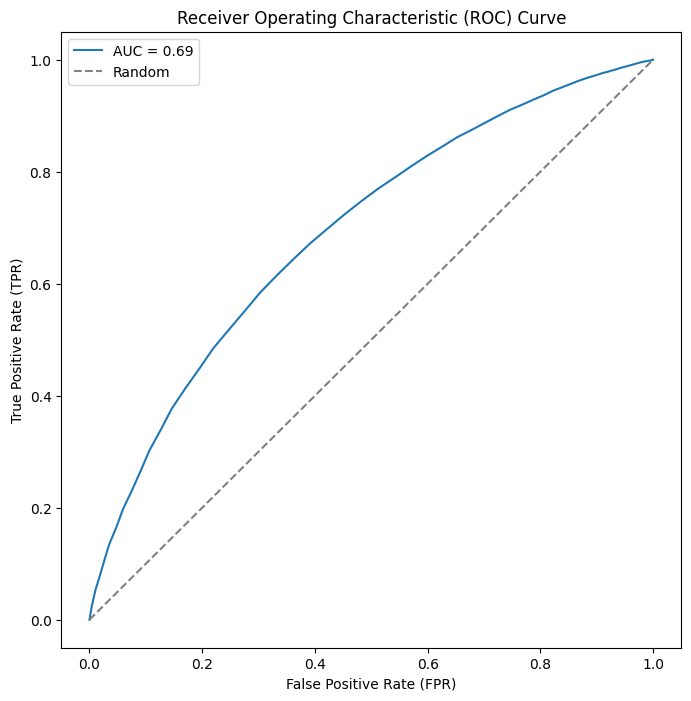

In [45]:
# Assuming you have the predicted probabilities for the positive class
y_prob_test = clf.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob_test)
print("AUC Score:", auc_score)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.show()

# is 69 auc score good what does it mean, what can i do to increase it?

AUC is a performance metric used to evaluate the ability of a classification model to distinguish between positive and negative classes.
our AUC score is 0.7 that indicates that our model is effective enough at differentiating between positive and negative instances. out of 10 datas, it can identify 7 data's class

## Conclusion

In [28]:
import pickle
# wb to create new
with open('random_forest_model.pkl', 'wb') as file:
        pickle.dump(clf, file)